In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pprint import pprint

# Inverse Kinematics Equations
## calculate the angles from x, y, z coords

In [166]:
def get_angles(X, Y, Z, La=1, Lb=1):

    thC = np.arctan2(X, Z)
    x = np.sqrt(X**2 + Z**2)
    thA = np.arctan2(x, Y) - np.arccos((x**2+Y**2+La**2-Lb**2)/(2*np.sqrt(x**2+Y**2)*La))
    thB = np.pi - np.arccos((Lb**2 + La**2 - x**2 - Y**2)/(2*La*Lb))
    return thA, thB, thC

In [167]:
def get_angles_2(X, Y, Z, P, T, La=1, Lb=1, Lc=1):
    # put request position into vector form
    X = np.array([X, Y, Z])

    # work out the new position needed, given the pan & tilt of the final arm
    dX = Lc * np.array([np.cos(T) * np.cos(P),
                        np.sin(T),
                        np.cos(T) * np.sin(P)])
    new_X = X - dX

    # now find the angles thA, thB, thC needed to get to that position
    thA, thB, thC = get_angles(new_X[0], new_X[1], new_X[2], La, Lb)

    # use the arm angles and the pan-tilt value to find motor positions
    trans_M = np.array([[np.cos(thA+thB)*np.cos(thC), np.sin(thA+thB)*np.cos(thC), np.sin(thC)],
                        [-np.sin(thA+thB), np.cos(thA+thB), 0],
                        [np.cos(thA+thB)*np.sin(thC), np.sin(thA+thB)*np.sin(thC), np.cos(thC)]])

    dx = np.linalg.inv(trans_M).dot(dX)

    alpha = np.arctan2(dx[2], dx[0])
    beta = np.arcsin(dx[1]/Lc)

    return thA, thB, thC, alpha, beta

get_angles_2(1, 1, 1, 0, 0)

In [168]:
# create a list of X positions
"""Line
Xs = np.linspace(1, -1, 100) + 0.5
Ys = np.zeros(100) + 0.5
Zs = np.zeros(100) + 0.5
"""
"""Square
frames = 100
xp = np.linspace(0, frames, 5)
Zs = np.interp(np.linspace(0, frames, frames-1), xp, [1, 1, 1, 1, 1])
Ys = np.interp(np.linspace(0, frames, frames-1), xp, [-1, -1, 1, 1, -1])
Xs = np.interp(np.linspace(0, frames, frames-1), xp, [-1, 1, 1, -1, -1])
"""

""" Circle"""
frames = 70
i = np.linspace(0, 2*np.pi, frames)
Xs = 0.5*np.sin(i) + 1
Zs = 0.5*np.cos(i) + 1
Ys = np.zeros(frames) + 0.5
Ps = np.zeros(frames)
Ts = np.zeros(frames)


thAs, thBs, thCs, thDs, thEs = [],[],[],[],[]
for i in range(frames):
    thA, thB, thC, thD, thE = get_angles_2(Xs[i], Ys[i], Zs[i], Ps[i], Ts[i])

    thAs.append(thA)
    thBs.append(thB)
    thCs.append(thC)
    thDs.append(thD)
    thEs.append(thE)

thAs = np.array(thAs)
thBs = np.array(thBs)
thCs = np.array(thCs)
thDs = np.array(thDs)
thEs = np.array(thEs)


thDs, thEs = np.zeros(frames), np.zeros(frames)


/Users/will/opt/anaconda3/envs/durhamPy37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arcsin


# 3D Forward Kinematics

In [78]:
def arm_coords_5dof(tha, thb, thc, thd, the, la=1, lb=1, lc=1, ld=1):

    # get the incremental coordinates from the angles
    T = tha + thb + thc
    y_points = np.array([np.zeros(len(tha)),
                         la*np.cos(tha),
                         lb*np.cos(tha+thb),
                         lc*np.cos(T),
                         ld*np.cos(T)*np.cos(the)]).transpose((1,0))

    x_points = np.array([np.zeros(len(tha)),
                         la*np.sin(tha)*np.cos(thd),
                         lb*np.sin(tha+thb)*np.cos(thd),
                         lc*np.sin(T)*np.cos(thd),
                         ld*np.sin(T)*np.cos(thd)*np.cos(the) - ld*np.sin(the)*np.sin(thd)]).transpose((1,0))

    z_points = np.array([np.zeros(len(tha)),
                         la*np.sin(tha)*np.sin(thd),
                         lb*np.sin(tha+thb)*np.sin(thd),
                         lc*np.sin(T)*np.sin(thd),
                         ld*np.sin(T)*np.sin(thd)*np.cos(the) + ld*np.sin(the)*np.cos(thd)]).transpose((1,0))

    # get the absolute coordinates from the incremental coords
    x_points = np.cumsum(x_points, axis=1)
    y_points = np.cumsum(y_points, axis=1)
    z_points = np.cumsum(z_points, axis=1)


    return x_points, y_points, z_points

tha = thb = thc = np.linspace(0, np.pi/3, 10)
the = thd = np.zeros(10)

x_points, y_points, z_points = arm_coords_5dof(tha, thb, thc, thd, the)

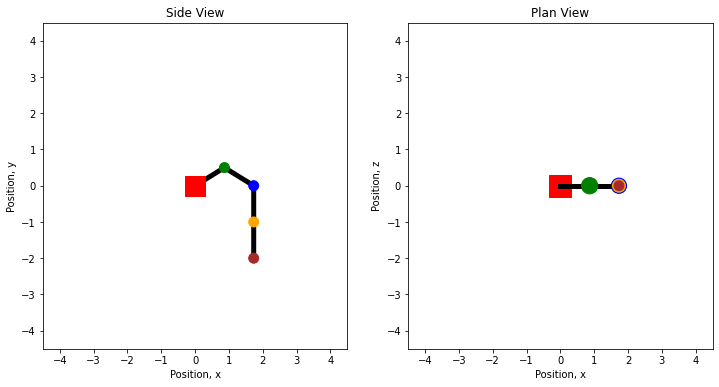

In [79]:
def animate_5dof(x_points, y_points, z_points, thAs=None, thBs=None, thCs=None):
    if not (thAs is None or thBs is None or thCs is None):
        big_plot = True
        thAs, thBs, thCs = thAs*180/np.pi, thBs*180/np.pi, thCs*180/np.pi
    else:
        big_plot=False

    # get bounds for marker sizes
    size_bounds_x = [np.min(np.min(x_points, axis=1)), np.max(np.max(x_points, axis=1))]
    size_bounds_z = [np.min(np.min(z_points, axis=1)), np.max(np.max(z_points, axis=1))]
    size_bounds_y = [np.min(np.min(y_points, axis=1)), np.max(np.max(y_points, axis=1))]


    # the animation
    if big_plot:
        fig = plt.figure(figsize=(12, 12))
        ax1 = plt.subplot(2,2,1)
        ax2 = plt.subplot(2,2,2)
        ax3 = plt.subplot(2,1,2)

        ax3.set_xlim([0, len(thAs)])
        ax3.set_ylim([np.min([np.min(thCs), np.min(thAs), np.min(thBs)]), np.max([np.max(thCs), np.max(thAs), np.max(thBs)])])
        ax3.plot(thAs[:1], label="$\\theta_a$")
        ax3.plot(thBs[:1], label="$\\theta_b$")
        ax3.plot(thCs[:1], label="$\\theta_c$")
        ax3.legend()
        ax3.set_title("Motor Angles")
        ax3.set_xlabel("Time")
        ax3.set_ylabel("Motor Angle (degrees)")
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    def construct_frame(i):
        xpoints = x_points[i,:]
        ypoints = y_points[i,:]
        zpoints = z_points[i,:]

        # Side on view of the robot
        ax1.clear()
        ax1.set_xlim([-4.5, 4.5])
        ax1.set_ylim([-4.5, 4.5])
        ax1.plot(xpoints, ypoints, linewidth=5, color="black", zorder=1)
        ax1.plot(0, 0, 's', markersize=20, color="red", zorder=2)
        ax1.scatter(x=xpoints[1:], y=ypoints[1:], s=np.interp(zpoints[1:], size_bounds_z, [500, 100]), c=["green", "blue", "orange", "brown"], zorder=3)
        ax1.set_xlabel("Position, x")
        ax1.set_ylabel("Position, y")
        ax1.set_title("Side View")

        # top down view of the robot
        ax2.clear()
        ax2.set_xlim([-4.5, 4.5])
        ax2.set_ylim([-4.5, 4.5])
        ax2.plot(xpoints, zpoints, linewidth=5, color="black", zorder=2)
        ax2.plot(0, 0, marker=(4, 0, 45-(180/np.pi)*np.arctan2(xpoints[1], zpoints[1])), markersize=30, color="red", zorder=1)
        ax2.scatter(x=xpoints[1:], y=zpoints[1:], s=np.interp(ypoints[1:], size_bounds_y, [100, 500]), c=["green", "blue", "orange", "brown"], zorder=3)
        ax2.set_title("Plan View")
        ax2.set_xlabel("Position, x")
        ax2.set_ylabel("Position, z")

        if big_plot:
            # log of motor positions
            ax3.plot(thAs[:i], label="$\\theta_a$", color="blue")
            ax3.plot(thBs[:i], label="$\\theta_b$", color="orange")
            ax3.plot(thCs[:i], label="$\\theta_c$", color="green")

    # set ani variable to call the
    # function recursively
    anim = FuncAnimation(fig, construct_frame, interval=1, frames=len(x_points[:,1]))
    anim.save("out.mp4", fps=24, dpi=200)

animate_5dof(x_points, y_points, z_points)

In [169]:
def arm_coords_2(thAs, thBs, thCs, thDs, thEs, La=1, Lb=1, Lc=1):
    # for the pan-tilt
    dx = Lc * np.array([np.cos(thEs) * np.sin(thDs),
                        np.sin(thEs),
                        np.cos(thEs) * np.cos(thDs)]).transpose((1,0))

    trans_M = np.array([[np.cos(thAs+thBs)*np.cos(thCs), np.sin(thAs+thBs)*np.cos(thCs), np.cos(thAs+thBs)*np.sin(thCs)],
                        [-np.sin(thAs+thBs), np.cos(thAs+thBs), -np.sin(thAs+thBs)],
                        [-np.cos(thAs+thBs)*np.sin(thCs), np.sin(thAs+thBs)*np.sin(thCs), np.cos(thAs+thBs)*np.cos(thCs)]]).transpose((2,0,1))

    nt = len(thAs)

    dX = np.array([trans_M[i,:,:].dot(dx[i,:]) for i in range(nt)])

    # now the rest of the arm (XYZ) as well
    ra = La * np.sin(thAs)
    rb = Lb * np.sin(thAs + thBs)

    A1x = ra * np.sin(thCs)
    A2x = (ra + rb) * np.sin(thCs)
    A3x = A2x + dX[:,0]

    A1y = La * np.cos(thAs)
    A2y = A1y + Lb*np.cos(thAs + thBs)
    A3y = A2y + dX[:,1]

    A1z = ra*np.cos(thCs)
    A2z = (ra+rb) * np.cos(thCs)
    A3z = A2z + dX[:,2]

    arm_2_coords = np.concatenate(([A2x], [A2y], [A2z])).round(10).transpose((1,0))
    arm_3_coords = np.concatenate(([A3x], [A3y], [A3z])).round(10).transpose((1,0))
    arm_1_coords = np.concatenate(([A1x], [A1y], [A1z])).round(10).transpose((1,0))

    return arm_1_coords, arm_2_coords, arm_3_coords
f = 10
thAs, thBs, thCs = np.zeros(f), np.zeros(f)+np.pi/2, np.zeros(f)+np.pi/2
thDs, thEs = np.linspace(0, np.pi/2, f), np.zeros(f)
arm_1_coords, arm_2_coords, arm_3_coords = arm_coords_2(thAs, thBs, thCs, thDs, thEs)


In [171]:
def arm_coords(thAs, thBs, thCs, La=1, Lb=1):
    ra = La * np.sin(thAs)
    rb = Lb * np.sin(thAs + thBs)

    A1x = ra * np.sin(thCs)
    A2x = (ra + rb) * np.sin(thCs)

    A1y = La * np.cos(thAs)
    A2y = A1y + Lb*np.cos(thAs + thBs)

    A1z = ra*np.cos(thCs)
    A2z = (ra+rb) * np.cos(thCs)

    arm_1_coords = np.concatenate(([A1x], [A1y], [A1z])).round(10)
    arm_2_coords = np.concatenate(([A2x], [A2y], [A2z])).round(10)

    return arm_1_coords, arm_2_coords